<a href="https://www.kaggle.com/baraknetef/optilver-eda-regression?scriptVersionId=87975424" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

The data:
112 stocks book samples over 10 min time buckets
112 stocks trade data over 10 min time buckets

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
files=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))


In [2]:
s='86'
sf=[]
sf=[file for file in files if str('=' + s) in file]

In [3]:
a=pd.read_parquet(sf[0])
b=pd.read_parquet(sf[1])
a.info(),b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402505 entries, 0 to 402504
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time_id            402505 non-null  int16  
 1   seconds_in_bucket  402505 non-null  int16  
 2   price              402505 non-null  float32
 3   size               402505 non-null  int32  
 4   order_count        402505 non-null  int16  
dtypes: float32(1), int16(3), int32(1)
memory usage: 5.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773824 entries, 0 to 1773823
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   time_id            int16  
 1   seconds_in_bucket  int16  
 2   bid_price1         float32
 3   ask_price1         float32
 4   bid_price2         float32
 5   ask_price2         float32
 6   bid_size1          int32  
 7   ask_size1          int32  
 8   bid_size2          int32  
 9   ask_size2        

(None, None)

In [4]:
b.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001321,1.001674,1.001145,1.001850,100,206,500,224
1,5,1,1.001321,1.001674,1.001145,1.001850,109,206,500,324
2,5,2,1.001321,1.001674,1.001145,1.001850,109,106,500,324
3,5,3,1.001321,1.001674,1.001145,1.001850,239,106,500,324
4,5,6,1.001674,1.001850,1.001498,1.002026,100,100,144,332


array([[<AxesSubplot:title={'center':'seconds_in_bucket'}>,
        <AxesSubplot:title={'center':'time_id'}>]], dtype=object)

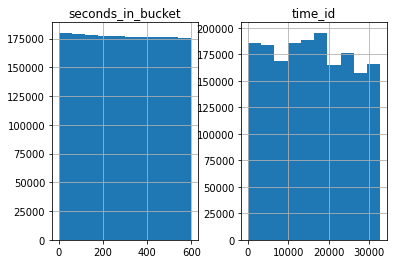

In [5]:
b[['seconds_in_bucket','time_id']].hist()

In [6]:
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402505 entries, 0 to 402504
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time_id            402505 non-null  int16  
 1   seconds_in_bucket  402505 non-null  int16  
 2   price              402505 non-null  float32
 3   size               402505 non-null  int32  
 4   order_count        402505 non-null  int16  
dtypes: float32(1), int16(3), int32(1)
memory usage: 5.4 MB


<AxesSubplot:>

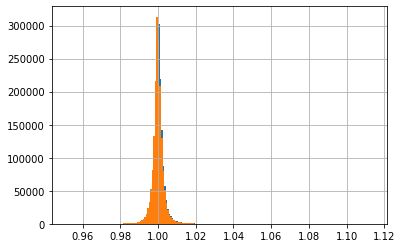

In [7]:
b.ask_price1.hist(bins=200)
b.bid_price1.hist(bins=200)

In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split as split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score


list_order_book_file_train = glob.glob('/kaggle/input/optiver-realized-volatility-prediction/book_train.parquet/*')
list_trade_file_train = glob.glob('/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/*')
train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))
def rmspe(y, y_pred):
    return  (np.sqrt(np.mean(np.square((y - y_pred) / y))))

# Feature creation
This code creates raw features based on the raw data:
from the book data, per stock and time bucket:
- realized volatility
- sum of log returns
- sum of bid and ask sizes for each level
- mean spread

from the trade data, per stock and time bucket:
- trade size
- order count

*trade price is left out since it is accaunted for by 'wap'

In [9]:
def book_features(file_path, prediction_column_name):
    df_book_data = pd.read_parquet(file_path)
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])  / (
                                      df_book_data['bid_size1']+ df_book_data[
                                  'ask_size1'])
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    df_book_data['spread'] = df_book_data['ask_price1'] - df_book_data['bid_price1']
    df_book_features =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_book_features = df_book_features.rename(columns = {'log_return':prediction_column_name})
    df_agg_data = pd.DataFrame(df_book_data.groupby(['time_id'])[['log_return','bid_size1','ask_size1','bid_size2','ask_size2']].sum()).reset_index()
    stock_id = file_path.split('=')[1]
    df_book_features['stock_id'] = stock_id
    df_agg_data = df_agg_data.rename(columns = {'log_return':'sum_log_return'})
    df_agg_data['row_id'] = df_agg_data['time_id'].apply(lambda x:f'{stock_id}-{x}')
    df_spread = pd.DataFrame(df_book_data.groupby(['time_id'])['spread'].mean()).reset_index()
    df_spread['row_id'] = df_spread['time_id'].apply(lambda x:f'{stock_id}-{x}')                        
    df_book_features = df_book_features.merge(df_agg_data)
    df_book_features = df_book_features.merge(df_spread)                         
    return df_book_features

df_book_features = pd.DataFrame()
for file in list_order_book_file_train:
    a=book_features(file,prediction_column_name='realized_vol')
    df_book_features=pd.concat([df_book_features,a])

**The resulting book features df:**

In [10]:
df_book_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428932 entries, 0 to 3829
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   time_id         428932 non-null  int64  
 1   realized_vol    428932 non-null  float64
 2   stock_id        428932 non-null  object 
 3   sum_log_return  428932 non-null  float64
 4   bid_size1       428932 non-null  int32  
 5   ask_size1       428932 non-null  int32  
 6   bid_size2       428932 non-null  int32  
 7   ask_size2       428932 non-null  int32  
 8   row_id          428932 non-null  object 
 9   spread          428932 non-null  float32
dtypes: float32(1), float64(2), int32(4), int64(1), object(2)
memory usage: 27.8+ MB


In [11]:
def trade_features(file_path):
    df_trade_data = pd.read_parquet(file_path)
    df_trade_features =  pd.DataFrame(df_trade_data.groupby(['time_id'])[['size','order_count']].sum()).reset_index()
    df_trade_features = df_trade_features.rename(columns = {'size':'trade_size'})
    stock_id = file_path.split('=')[1]
    df_trade_features['stock_id'] = stock_id
    df_trade_features['row_id'] = df_trade_features['time_id'].apply(lambda x:f'{stock_id}-{x}')                                        
    return df_trade_features

df_trade_features = pd.DataFrame()
for file in list_trade_file_train:
    a=trade_features(file)
    df_trade_features=pd.concat([df_trade_features,a])

**the resulting trade data features df:**

In [12]:
df_trade_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428913 entries, 0 to 3829
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time_id      428913 non-null  int64  
 1   trade_size   428913 non-null  int32  
 2   order_count  428913 non-null  float64
 3   stock_id     428913 non-null  object 
 4   row_id       428913 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(2)
memory usage: 18.0+ MB


In [13]:
df_raw_features = df_book_features.merge(df_trade_features,how='left')

In [14]:
df_raw_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428932 entries, 0 to 428931
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   time_id         428932 non-null  int64  
 1   realized_vol    428932 non-null  float64
 2   stock_id        428932 non-null  object 
 3   sum_log_return  428932 non-null  float64
 4   bid_size1       428932 non-null  int32  
 5   ask_size1       428932 non-null  int32  
 6   bid_size2       428932 non-null  int32  
 7   ask_size2       428932 non-null  int32  
 8   row_id          428932 non-null  object 
 9   spread          428932 non-null  float32
 10  trade_size      428913 non-null  float64
 11  order_count     428913 non-null  float64
dtypes: float32(1), float64(4), int32(4), int64(1), object(2)
memory usage: 34.4+ MB


In [15]:
df_trade_features.stock_id.nunique()

112

# Feature engeneering

First we will calculate the future realized volatility for each time bucket and stock (this is the target).

by doing that we have to depart with all the last time buckets - it won't have future data.

In [16]:
df_raw_features['future_vol'] = df_raw_features.groupby(['stock_id'])['realized_vol'].shift(-1)
df_raw_features = df_raw_features[~df_raw_features['future_vol'].isnull()]

The bid and ask sizes will be used to claculate the book depth:
- the ratio between first level bid and ask i.e. 'baratio'
- the ratio between the bid size and the average time bucket trade size i.e. 'bratio'
- the ratio between the ask size and the average time bucket trade size i.e. 'aratio'
- the average order

In [17]:
df_raw_features.groupby(['stock_id','time_id'])['trade_size'].sum().unstack().mean(axis=1)

stock_id
0       3212.798120
1      12534.468007
10     40359.979368
100    16887.101097
101    15851.581614
           ...     
95     21858.205014
96     21449.228780
97      6757.893184
98      3094.431705
99     50423.252024
Length: 112, dtype: float64

In [18]:
df_raw_features['baratio'] = df_raw_features['bid_size1'] / df_raw_features['ask_size1']
sizes = df_raw_features.groupby(['stock_id','time_id'])['trade_size'].sum().unstack().mean(axis=1)
df_raw_features = df_raw_features.merge(sizes.rename('mean_trade_size'), left_on='stock_id', right_on='stock_id')
df_raw_features['bratio']=(df_raw_features['bid_size1'] + df_raw_features['bid_size2'])/df_raw_features['mean_trade_size']
df_raw_features['aratio']=(df_raw_features['ask_size1'] + df_raw_features['ask_size2'])/df_raw_features['mean_trade_size']
df_raw_features['mean_order']=df_raw_features['trade_size']/df_raw_features['order_count']
df_raw_features.head()

,time_id,realized_vol,stock_id,sum_log_return,bid_size1,ask_size1,bid_size2,ask_size2,row_id,spread,trade_size,order_count,future_vol,baratio,mean_trade_size,bratio,aratio,mean_order
0,5,0.007263,97,-0.003268,38620,31606,22985,24610,97-5,0.001480,3971.0,132.0,0.002919,1.221920,6757.893184,9.116007,8.318569,30.083333
1,11,0.002919,97,-0.002379,37282,9323,18037,18603,97-11,0.000808,1944.0,87.0,0.003799,3.998927,6757.893184,8.185835,4.132353,22.344828
2,16,0.003799,97,-0.002486,28650,34528,50441,30566,97-16,0.000604,5336.0,109.0,0.003753,0.829761,6757.893184,11.703500,9.632292,48.954128
3,31,0.003753,97,-0.000307,30859,14314,30172,12741,97-31,0.001123,4283.0,120.0,0.004365,2.155861,6757.893184,9.031069,4.003467,35.691667
4,62,0.004365,97,-0.001412,21992,18595,24520,20476,97-62,0.001365,2919.0,70.0,0.015294,1.182684,6757.893184,6.882618,5.781536,41.700000


In [19]:
# df_raw_features['bratio']=(df_raw_features['bid_size1'] + df_raw_features['bid_size2'])/df_raw_features['mean_trade_size']
# df_raw_features['aratio']=(df_raw_features['ask_size1'] + df_raw_features['ask_size2'])/df_raw_features['mean_trade_size']
df_raw_features.head()

,time_id,realized_vol,stock_id,sum_log_return,bid_size1,ask_size1,bid_size2,ask_size2,row_id,spread,trade_size,order_count,future_vol,baratio,mean_trade_size,bratio,aratio,mean_order
0,5,0.007263,97,-0.003268,38620,31606,22985,24610,97-5,0.001480,3971.0,132.0,0.002919,1.221920,6757.893184,9.116007,8.318569,30.083333
1,11,0.002919,97,-0.002379,37282,9323,18037,18603,97-11,0.000808,1944.0,87.0,0.003799,3.998927,6757.893184,8.185835,4.132353,22.344828
2,16,0.003799,97,-0.002486,28650,34528,50441,30566,97-16,0.000604,5336.0,109.0,0.003753,0.829761,6757.893184,11.703500,9.632292,48.954128
3,31,0.003753,97,-0.000307,30859,14314,30172,12741,97-31,0.001123,4283.0,120.0,0.004365,2.155861,6757.893184,9.031069,4.003467,35.691667
4,62,0.004365,97,-0.001412,21992,18595,24520,20476,97-62,0.001365,2919.0,70.0,0.015294,1.182684,6757.893184,6.882618,5.781536,41.700000


- most of the features seem to distribute log normaly. so in order for them to fit the scale of our target - I will log them

Transformations

In [20]:
logged = df_raw_features[['spread','baratio','bratio','aratio','mean_order']]
logged = np.log1p(logged)
#hundreds = df_raw_features[['realized_vol','future_vol']]*100

# EDA
now we will see some analysis of the calculated features

In [21]:
df_final_features = df_raw_features.copy()[['time_id','stock_id','row_id','realized_vol','future_vol', 'sum_log_return']]
df_final_features = df_final_features.merge(logged,left_index=True, right_index=True)
#df_final_features = df_final_features.merge(hundreds,left_index=True, right_index=True)
df_final_features.head()

,time_id,stock_id,row_id,realized_vol,future_vol,sum_log_return,spread,baratio,bratio,aratio,mean_order
0,5,97,97-5,0.007263,0.002919,-0.003268,0.001479,0.798372,2.314119,2.232009,3.436672
1,11,97,97-11,0.002919,0.003799,-0.002379,0.000808,1.609223,2.217663,1.635564,3.150375
2,16,97,97-16,0.003799,0.003753,-0.002486,0.000604,0.604186,2.541878,2.363896,3.911105
3,31,97,97-31,0.003753,0.004365,-0.000307,0.001123,1.149261,2.305687,1.610131,3.602550
4,62,97,97-62,0.004365,0.015294,-0.001412,0.001364,0.780555,2.064660,1.914204,3.754199


# Removing outliars

In [22]:
df_final_features = df_final_features[df_final_features['future_vol']<0.06]
df_final_features = df_final_features[df_final_features['realized_vol']<0.06]
df_final_features = df_final_features[df_final_features['spread']<0.012]

In [23]:
len(df_final_features)

428770

array([[<AxesSubplot:title={'center':'time_id'}>,
        <AxesSubplot:title={'center':'realized_vol'}>,
        <AxesSubplot:title={'center':'future_vol'}>],
       [<AxesSubplot:title={'center':'sum_log_return'}>,
        <AxesSubplot:title={'center':'spread'}>,
        <AxesSubplot:title={'center':'baratio'}>],
       [<AxesSubplot:title={'center':'bratio'}>,
        <AxesSubplot:title={'center':'aratio'}>,
        <AxesSubplot:title={'center':'mean_order'}>]], dtype=object)

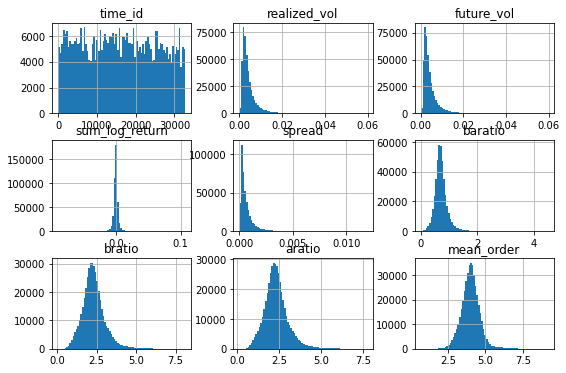

In [24]:
df_final_features.hist(bins=80,figsize=(9,6))

- on most cases the features seem to distribute log normaly (except for the returns which are allready logged)

,time_id,realized_vol,future_vol,sum_log_return,spread,baratio,bratio,aratio,mean_order
time_id,1.000000,-0.004898,-0.005267,-0.004656,-0.002884,-0.000206,-0.005201,-0.005686,-0.003691
realized_vol,-0.004898,1.000000,0.159163,-0.022562,0.841847,-0.000985,-0.051029,-0.043551,-0.135878
future_vol,-0.005267,0.159163,1.000000,0.007505,0.210001,0.010959,-0.068424,-0.064298,-0.216020
sum_log_return,-0.004656,-0.022562,0.007505,1.000000,-0.011981,0.066163,0.018684,-0.009045,0.013571
spread,-0.002884,0.841847,0.210001,-0.011981,1.000000,0.024539,0.041097,0.047714,-0.268978
baratio,-0.000206,-0.000985,0.010959,0.066163,0.024539,1.000000,0.215256,-0.199650,-0.041946
bratio,-0.005201,-0.051029,-0.068424,0.018684,0.041097,0.215256,1.000000,0.884316,0.451553
aratio,-0.005686,-0.043551,-0.064298,-0.009045,0.047714,-0.199650,0.884316,1.000000,0.450517
mean_order,-0.003691,-0.135878,-0.216020,0.013571,-0.268978,-0.041946,0.451553,0.450517,1.000000


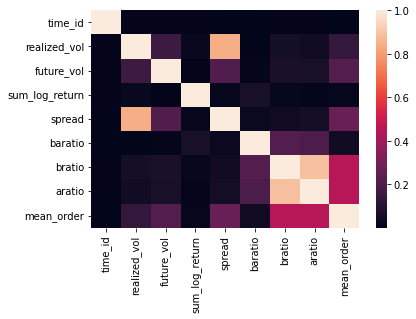

In [25]:
sns.heatmap(df_final_features.corr().abs())
df_final_features.corr()

Index(['time_id', 'stock_id', 'row_id', 'realized_vol', 'future_vol',
       'sum_log_return', 'spread', 'baratio', 'bratio', 'aratio',
       'mean_order'],
      dtype='object')

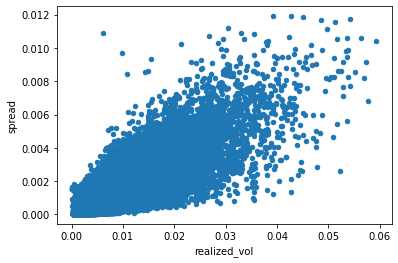

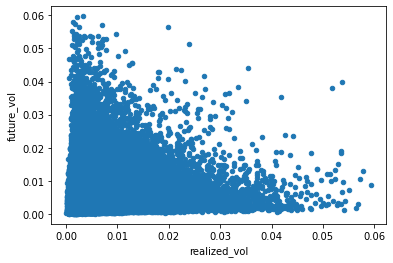

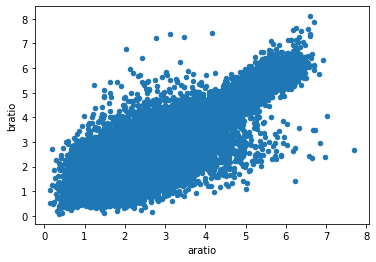

In [26]:
#sns.pairplot(df_final_features.iloc[:,2:], height=1.5)
df_final_features.plot.scatter('realized_vol','spread')
df_final_features.plot.scatter('realized_vol','future_vol')
df_final_features.plot.scatter('aratio','bratio')
df_final_features.columns

- the spread is heavily correlated with the realized volatility
- the ask ratio and the bid ratio are correlated, but the scatter isn't so clear. 
remove one? log them?
- the other features are not very correlated to each other and to the target. 
- question - the outliers indicate special trade points. do we leave them? seperate?

In [27]:
df_final_features.head()

,time_id,stock_id,row_id,realized_vol,future_vol,sum_log_return,spread,baratio,bratio,aratio,mean_order
0,5,97,97-5,0.007263,0.002919,-0.003268,0.001479,0.798372,2.314119,2.232009,3.436672
1,11,97,97-11,0.002919,0.003799,-0.002379,0.000808,1.609223,2.217663,1.635564,3.150375
2,16,97,97-16,0.003799,0.003753,-0.002486,0.000604,0.604186,2.541878,2.363896,3.911105
3,31,97,97-31,0.003753,0.004365,-0.000307,0.001123,1.149261,2.305687,1.610131,3.602550
4,62,97,97-62,0.004365,0.015294,-0.001412,0.001364,0.780555,2.064660,1.914204,3.754199


# Linear Regression
- aratio and bratio are correleted. so for the linear regression I'll use only one 

In [28]:
#df_final_features.columns
X = df_final_features[['realized_vol','sum_log_return','spread','baratio','bratio']]
y = df_final_features['future_vol']
lin_model_1 = LinearRegression(fit_intercept=False).fit(X, y)

In [29]:
list(zip(X.columns, lin_model_1.coef_))

[('realized_vol', 0.05487399258014617),
 ('sum_log_return', -0.002469115903209276),
 ('spread', 1.1680870690211582),
 ('baratio', 0.0028590185765978854),
 ('bratio', 0.00041616666813715664)]

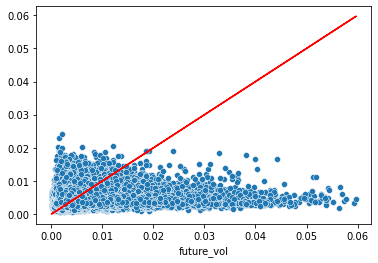

In [30]:
y_pred = lin_model_1.predict(X)
ax = sns.scatterplot(x=y, y=y_pred)
ax.plot(y, y, 'r')

In [31]:
mse(y, y_pred, squared=False)

0.0036016857029429468

In [32]:
R2 = round(r2_score(y_true = y, y_pred = y_pred),3)
RMSPE = round(rmspe(y = y, y_pred = y_pred),3)
print(f'Performance of the linear prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the linear prediction: R2 score: -0.024, RMSPE: 1.106


# Decision Tree

In [33]:
X = df_final_features[['realized_vol','sum_log_return','spread','baratio','bratio','aratio']]
y = df_final_features['future_vol']
dt_model_1 = DecisionTreeRegressor(max_leaf_nodes=1000).fit(X, y)

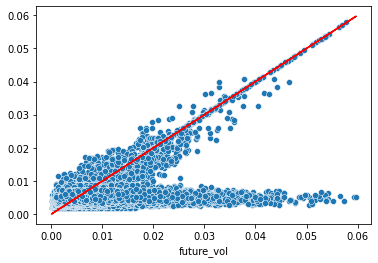

In [34]:
y_pred = dt_model_1.predict(X)
ax = sns.scatterplot(x=y, y=y_pred)
ax.plot(y, y, 'r')

<AxesSubplot:>

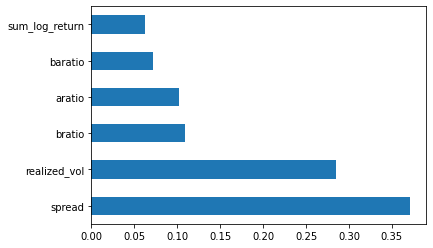

In [35]:
pd.Series(dt_model_1.feature_importances_,
          index=X.columns).sort_values(ascending=False).plot.barh()

In [36]:
msle(y, y_pred)**0.5

0.003267617684916963

In [37]:
R2 = round(r2_score(y_true = y, y_pred = y_pred),3)
RMSPE = round(rmspe(y = y, y_pred = y_pred),3)
print(f'Performance of DT model: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of DT model: R2 score: 0.141, RMSPE: 1.009


# KNN

In [38]:
knn_model_1 = KNeighborsRegressor(n_neighbors=4).fit(X, y)
y_pred = knn_model_1.predict(X)

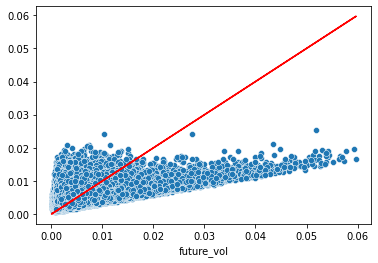

In [39]:
ax = sns.scatterplot(x=y, y=y_pred)
ax.plot(y, y, 'r')

In [40]:
R2 = round(r2_score(y_true = y, y_pred = y_pred),3)
RMSPE = round(rmspe(y = y, y_pred = y_pred),3)
print(f'Performance of KNN: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of KNN: R2 score: 0.277, RMSPE: 1.075


# Validating the Decision tree

> To be continued with better models